# Extracting track sections from coordinates

We want to split a race track into sections, based on the coordinates of the track.
A track can be considered of a series of corners and straights. 
A corner can be connected to another corner, or to a straight. 
See [driver61.com](https://driver61.com/uni/different-corner-technique/) explanation for more details.

The track features to be extracted are:
* the sequence of corners and straights
* the start and end of a sequence in meters on the track
  * the start of a corner is when the track starts to curve
  * the end of a corner is when the track starts to straighten out
* the curvature of a straight. Some straights are not completely straight, but have a slight curve.


Let's look at the Nürburgring track:
<br/>
 <img src="https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136" style="width: 50%;"/> 

The sequence would be:
1. straight "Start und Zielgerade"
2. corner "1"
3. corner "Mercedes Arena"
4. corner "3"
5. corner "4"
6. straight
7. corner "5"
8. corner "Ford Kurve"
9. straight
10. corner "Dunlop Kehre"
11. straight
12. corner "Michael Schumacher S"
13. corner 9
14. straight
15. corner "RTL Kurve"
16. straight
17. corner "Warsteiner Kurve"
18. straight
19. corner "ADVAN Bogen"
20. straight
21. corner "13"
22. corner "NGK Schikane"
23. corner "Coca-Cola Kurve"


Notice that a straight, like number 9, which connects "Ford-Kurve" and "Dunlop Kehre", might not be completely straight, but have a slight curve.


## source data

The data is stored in an InfluxDB database. It's collected from sim racing games. The game submits the telemetry data at a sample frequency of 60 Hz.
The coordinates are in the world coordinate system, which is different depending on the game. The coordinates are not in meters, but in some game specific unit. The coordinates are the position of the car in the world during a lap.
The start and end of a lap data is not 100% connected, since the car does not cross the the start and finish line at the very same coordinates.
The field `DistanceOnTrack` is the car position in meters on the track. This field will be used to add a length to each track section.

## data preparation

1. collect coordinates for multiple laps on a given track per game
   * since we record data from different cars and different drivers, we want to use many samples to get a statistically significant result.
2. map the coordinates to a universal coordinate system, which is the same for all games
   * every game uses slightly different units and x,y,z coordinates. To make the next steps universal, we need to normalize the data to a universal coordinate system. The coordinates can differ in scale and projection (like being mirrored)
3. remove outliers from laps
   * out of all the collected laps, calculate a single, well connected line, that is the best fit to the actual track. Some drivers have a different racing line on the track, or even spin the car during a lap.
4. split laps into sections, based on the data of all recorded laps
   * the extracted features are:
      * the sequence of corners and straights
      * every sequences has a start and end in meters
      * the end of sequence n is the start of sequence n+1


# Data exploration

The following is a data exploration of the data. It only shows 3 laps from 2 different games for 2 different tracks.
The data for the Nürburgring track shows 2 laps with car spins on the track to visualize the need for removing outliers and normalizing the data for a given track.
The data for Spa shows, that the coordinate system can be mirrored for a given game.

The actual data will be provided as SessionId and LapId combinations, for a set of tracks and games.
Per track the number of laps varies from 1 to 15. Total it will be approx 4 games with approx 10 tracks per game.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
import influxdb_client
from IPython.display import Image

from influxdb_client.client.write_api import SYNCHRONOUS

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

# configure influxdb client
ORG = "b4mad"
TOKEN = os.environ.get(
    "INFLUXDB_TOKEN",
    "citqAMr66LLb25hvaaZm2LezOc88k2ocOFJcJDR6QB-RmLJa_-sAr9kYB4vSFYaz8bt26lm7SokVgpQKdgKFKA==",
)
URL = "https://telemetry.b4mad.racing/"

client = influxdb_client.InfluxDBClient(url=URL, token=TOKEN, org=ORG)
query_api = client.query_api()
pd.set_option("display.max_columns", None)

In [2]:
# a function to query the database for a given session and lap
def query_session_lap(session, lap):
    query = f"""
    from(bucket: "racing")
    |> range(start: -10y, stop: now())
    |> filter(fn: (r) => r["_measurement"] == "laps_cc")
    |> filter(fn: (r) => r["SessionId"] == "{session}")
    |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r["CurrentLap"] == "{lap}")
    |> sort(columns: ["_time"], desc: false)
    """
    return query_api.query_data_frame(org=ORG, query=query)

In [3]:
tracks = {
    "Nurburgring_2020:Nurb_GP_2020_Veedol-1": {
        "game": "Automobilista 2",
        "session": 1670584820,
        "lap": 1,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136",
    },
    "Nurburgring_2020:Nurb_GP_2020_Veedol-2": {
        "game": "Automobilista 2",
        "session": 1670584820,
        "lap": 2,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136",
    },
    "Nurburgring_2020:Nurb_GP_2020_Veedol-3": {
        "game": "Automobilista 2",
        "session": 1670584820,
        "lap": 3,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136",
    },
    "Spa:track config": {
        "game": "Assetto Corsa Competizione",
        "session": 1670586823,
        "lap": 8,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/3/3f/Track_map_of_Spa-Francorchamps_in_Belgium.svg/revision/latest/scale-to-width-down/1000?cb=20120730120932",
    },
}

for track, data in tracks.items():
    tracks[track]["df"] = query_session_lap(data["session"], data["lap"])

'Nurburgring_2020:Nurb_GP_2020_Veedol-1'

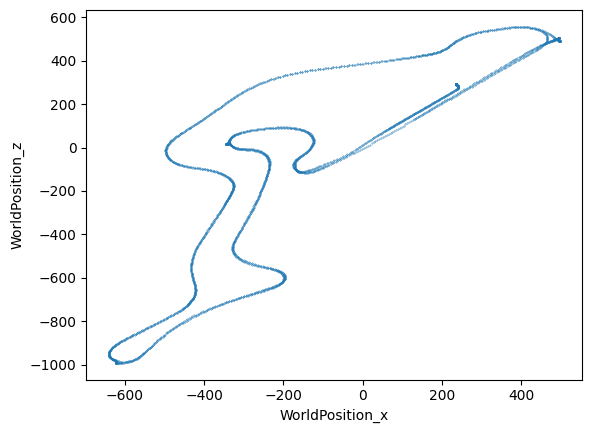

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapIsValid,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,LapTimePrevious,PreviousLapWasValid,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-15 09:17:53.702844+00:00,2022-12-15 21:17:53.702844+00:00,2022-12-09 12:20:20.626369+00:00,Porsche 911 RSR GTE,1,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,1.0,0.0,False,-3.000000,0.000,0.0,0.0,-1.0,True,0.000,0.00000,0.000000,0.0,235.758377,-6.537385,290.169400
3045,_result,0,2012-12-15 09:17:53.702844+00:00,2022-12-15 21:17:53.702844+00:00,2022-12-09 12:25:28.085268+00:00,Porsche 911 RSR GTE,1,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,138.926086,5123.455,5.0,0.0,-1.0,False,8127.544,62.82423,0.000763,1.0,129.348300,-7.737313,131.231552


'Nurburgring_2020:Nurb_GP_2020_Veedol-2'

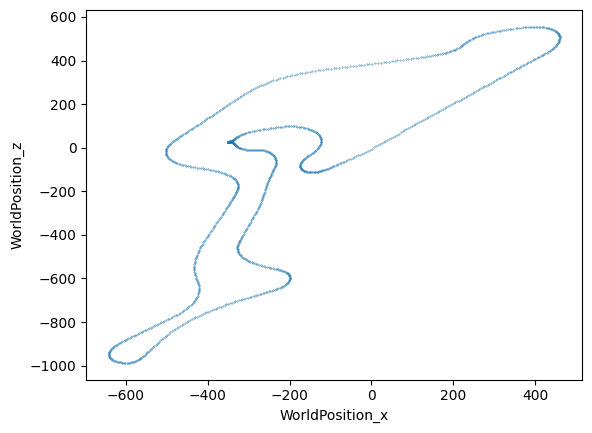

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapIsValid,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,LapTimePrevious,PreviousLapWasValid,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-15 09:17:56.195064+00:00,2022-12-15 21:17:56.195064+00:00,2022-12-09 12:25:28.196479+00:00,Porsche 911 RSR GTE,2,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,98.339294,4.459284,5.0,0.0,140.66626,True,8151.83057,63.058765,0.000611,1.0,125.050995,-7.807137,126.633125
1217,_result,0,2012-12-15 09:17:56.195064+00:00,2022-12-15 21:17:56.195064+00:00,2022-12-09 12:27:31.084774+00:00,Porsche 911 RSR GTE,2,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,103.855469,5123.926000,5.0,0.0,140.66626,True,8420.78100,65.099970,0.000305,1.0,130.214264,-7.705030,129.749466


'Nurburgring_2020:Nurb_GP_2020_Veedol-3'

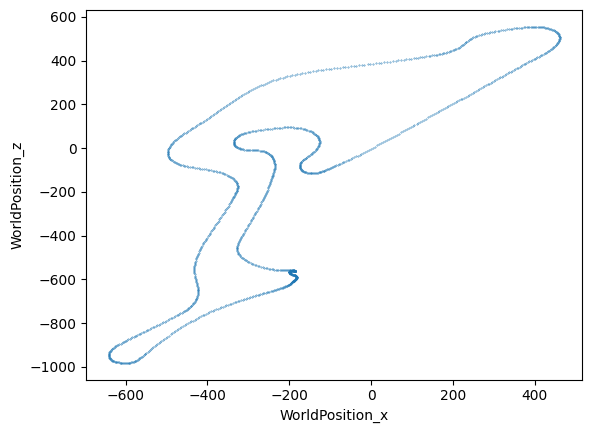

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapIsValid,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,LapTimePrevious,PreviousLapWasValid,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-15 09:17:57.702302+00:00,2022-12-15 21:17:57.702302+00:00,2022-12-09 12:27:31.193622+00:00,Porsche 911 RSR GTE,3,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,62.794130,6.14080,5.0,0.0,122.977844,True,8443.941,65.342804,0.000000,1.0,125.009926,-7.795475,124.348717
1358,_result,0,2012-12-15 09:17:57.702302+00:00,2022-12-15 21:17:57.702302+00:00,2022-12-09 12:29:48.316888+00:00,Porsche 911 RSR GTE,3,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,97.201904,5123.20068,5.0,0.0,122.977844,True,8457.679,65.405280,-0.000153,1.0,130.531418,-7.702488,130.450226


'Spa:track config'

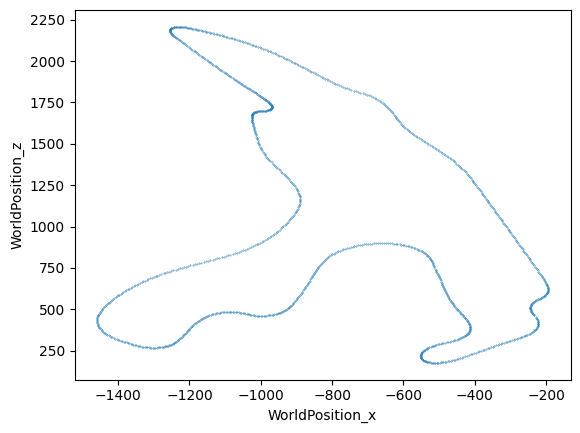

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-15 09:17:59.102411+00:00,2022-12-15 21:17:59.102411+00:00,2022-12-09 13:10:01.655171+00:00,Unknown,8,Assetto Corsa Competizione,1670586823,Race,Spa:track config,laps_cc,telegraf,crewchief/Jim/1670586823/Assetto Corsa Competi...,Jim,0.0,1.0,0.797,6.324125,4.0,0.0,5678.0,48.082325,0.0,1.0,-1082.61400,0.0,1903.51800
1274,_result,0,2012-12-15 09:17:59.102411+00:00,2022-12-15 21:17:59.102411+00:00,2022-12-09 13:12:21.624334+00:00,Unknown,8,Assetto Corsa Competizione,1670586823,Race,Spa:track config,laps_cc,telegraf,crewchief/Jim/1670586823/Assetto Corsa Competi...,Jim,0.0,1.0,0.520,7001.245610,4.0,0.0,5610.0,47.448100,0.0,1.0,-1078.21667,0.0,1895.76257


In [4]:
# iterate over all tracks
for track, data in tracks.items():
    df = data["df"]
    display(track)
    # scatter plot with a point size of 0.1
    if data["game"] == "Automobilista 2":
        df.plot.scatter(x="WorldPosition_x", y="WorldPosition_z", s=0.1)
    if data["game"] == "Assetto Corsa Competizione":
        # flip y axis
        df["WorldPosition_z"] = df["WorldPosition_z"] * -1
        df.plot.scatter(x="WorldPosition_x", y="WorldPosition_z", s=0.1)
    plt.show()
    display(Image(url=data["image"], width=800, unconfined=True))
    # display the first and last row of the dataframe
    display(pd.concat([df.head(1), df.tail(1)]))

## Preprocessing data

1. Some dataframes contains multiple laps. These multiple laps need to be split single laps.
2. In some laps vehicle goes out the track and driver goes revers. Driving reverse parts can be cleaned from data.
3. Telemetry data is missing yaw angle of the vehicle. This data should be calculated.
4. Yaw rate need to be calculated to segment corners and straight parts of track

### 1. Split the laps

It can be seen below, a single dataframe passes start point twice

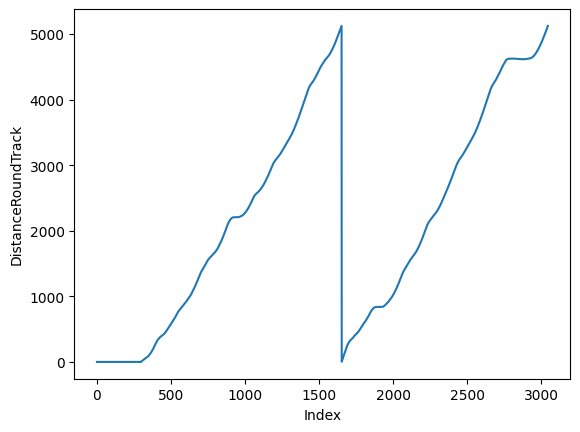

In [5]:
# Convert df data to numpy arrays
df = tracks["Nurburgring_2020:Nurb_GP_2020_Veedol-1"]["df"]
distances = df[['DistanceRoundTrack']].to_numpy()[:,0]
points = df[['WorldPosition_x','WorldPosition_z']].to_numpy()

plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')
plt.show()

When car passes start point, distance drops significantly. This information can be used to split laps

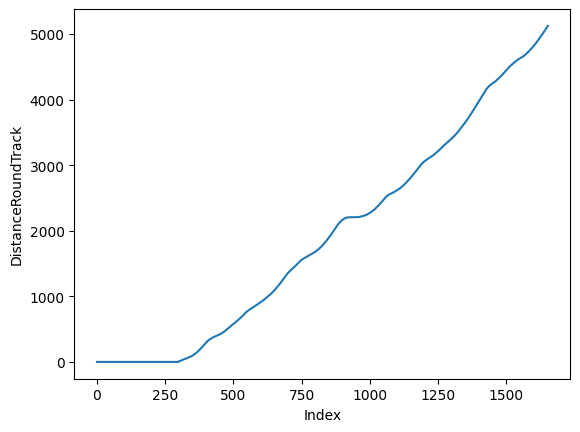

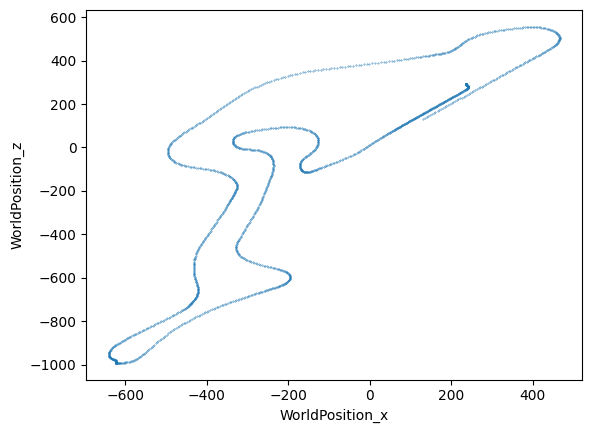

In [6]:
threshold = 100

laps = []
prev_idx = 0
for idx in range(1, distances.shape[0]):
    passed_start = distances[idx] - distances[idx-1] < -threshold
    last_point = (idx == distances.shape[0]-1)
    if passed_start or last_point:
        lap_distances = distances[prev_idx:idx]
        lap_points = points[prev_idx:idx]
        lap = {'distances': lap_distances,
               'points': lap_points}
        laps.append(lap)
        prev_idx = idx

plt.figure()
plt.plot(laps[0]['distances'])
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')

plt.figure()
x = laps[0]['points'][:,0]
y = laps[0]['points'][:,1]
plt.scatter(x, y, s=0.1)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()


### 2. Drop telemetry messages where DistanceRoundTrack is not increasing

DistanceRoundTrack value is not increasing in following conditions:
  * Car is driving reverse
  * Car is outside the track

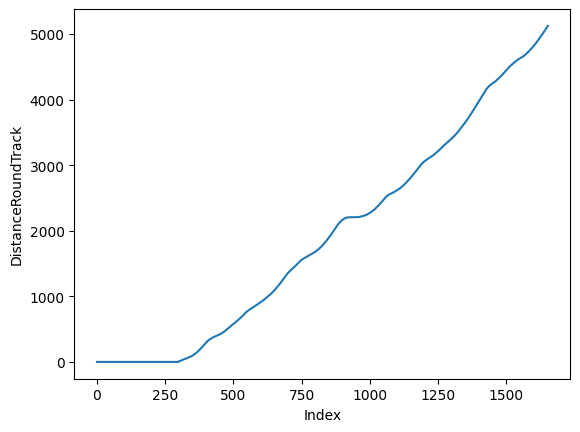

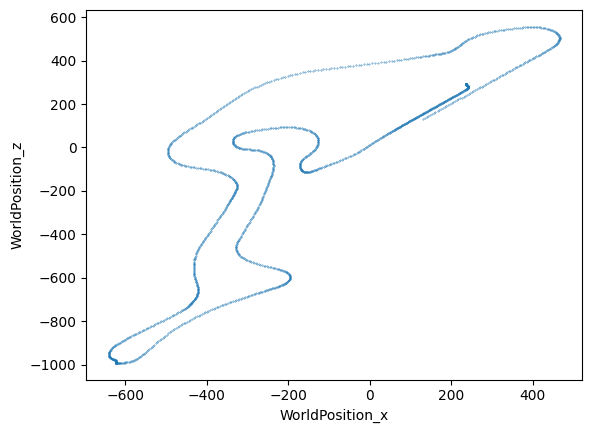

In [7]:
plt.figure()
plt.plot(laps[0]['distances'])
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')

plt.figure()
x = laps[0]['points'][:,0]
y = laps[0]['points'][:,1]
plt.scatter(x, y, s=0.1)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

These telemetry message are not need for calculations and they can be dropped.

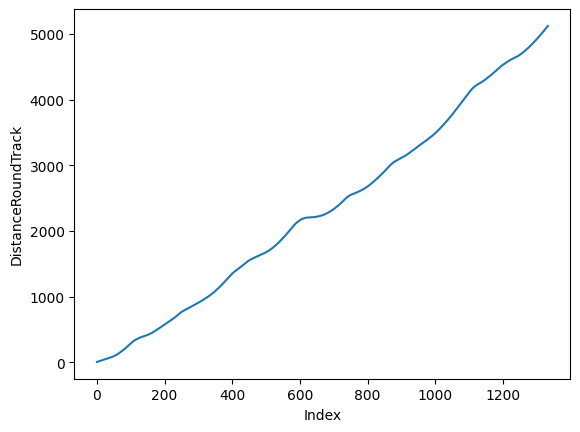

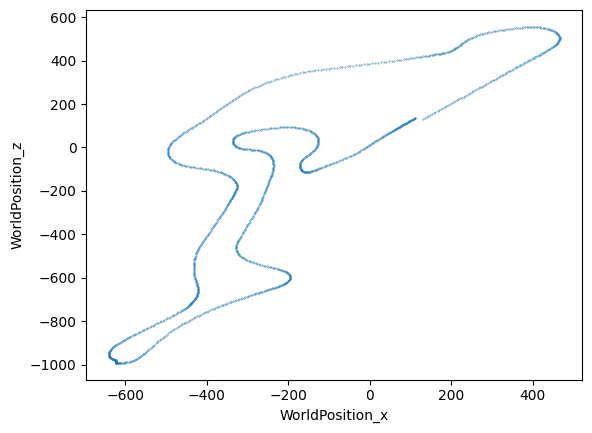

In [8]:
for lap_idx in range(len(laps)):
    distances = laps[lap_idx]['distances']
    points = laps[lap_idx]['points']

    max_distance = distances[0]
    selected_idx = []
    for idx in range(distances.shape[0]):
        if distances[idx] > max_distance:
            selected_idx.append(idx)
            max_distance = distances[idx]
    laps[lap_idx]['distances'] = distances[selected_idx]
    laps[lap_idx]['points'] = points[selected_idx]

plt.figure()
plt.plot(laps[0]['distances'])
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')

plt.figure()
x = laps[0]['points'][:,0]
y = laps[0]['points'][:,1]
plt.scatter(x, y, s=0.1)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

### 3. Calculate yaw angle by using position data

[[112.261009 136.31839 ]
 [111.121811 135.1234  ]
 [109.9828   133.928223]
 ...
 [139.603668 139.45932 ]
 [135.1854   134.805222]
 [130.75267  130.135239]]
[[121.324722 120.196777]
 [116.848549 115.477737]
 [112.353889 110.747116]
 ...
 [142.631348 145.457748]
 [138.457825 140.987549]
 [133.627838 135.81424 ]]


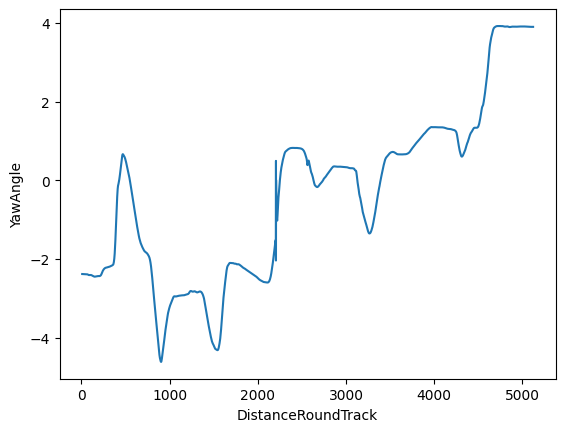

In [9]:
for lap_idx in range(len(laps)):
    distances = laps[lap_idx]['distances']
    points = laps[lap_idx]['points']
    print(points)

    differences = np.diff(points, axis=0)
    yaw_angles = np.arctan2(differences[:,0], differences[:,1])
    yaw_angles = np.unwrap(yaw_angles)
    
    laps[lap_idx]['distances'] = distances[1:]
    laps[lap_idx]['points'] = points[1:,:]
    laps[lap_idx]['yaw_angles'] = yaw_angles

plt.figure()
plt.plot(laps[0]['distances'], laps[0]['yaw_angles'])
plt.xlabel('DistanceRoundTrack')
plt.ylabel('YawAngle')
plt.show()

### 4. Calculate yaw rate by using yaw angle data

In [10]:
from scipy.spatial import ConvexHull
from scipy.ndimage import rotate

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T

    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

rectangle = minimum_bounding_rectangle(laps[0]['points'])
differences = np.diff(rectangle, axis=0)
denormalization_distance = np.linalg.norm(differences, axis=1).max()

print(denormalization_distance)

1863.8057506844502


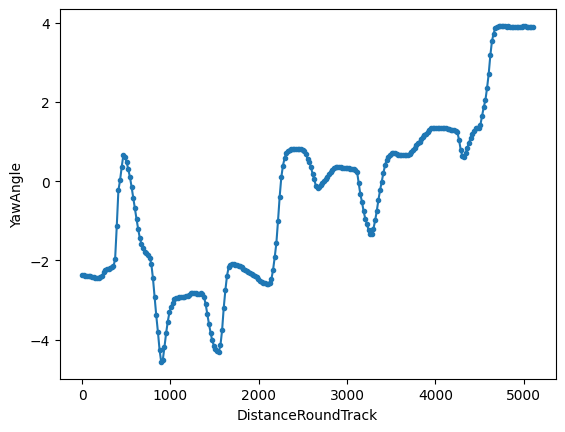

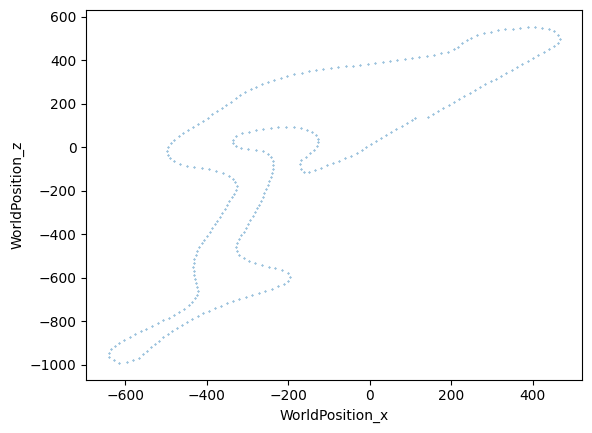

In [11]:
normalized_delta_distance = 0.01

track_distance = 0
for lap_idx in range(len(laps)):
     max_distance = laps[lap_idx]['distances'].max()
     if max_distance > track_distance:
        track_distance = max_distance

delta_distance = denormalization_distance * normalized_delta_distance
resampled_distances = np.arange(0, track_distance, delta_distance)
for lap_idx in range(len(laps)):
    distances = laps[lap_idx]['distances']
    points = laps[lap_idx]['points']
    yaw_angles = laps[lap_idx]['yaw_angles']

    resampled_x = np.interp(resampled_distances, distances, points[:,0]) 
    resampled_y = np.interp(resampled_distances, distances, points[:,1]) 
    resampled_yaw_angles = np.interp(resampled_distances, distances, yaw_angles) 

    laps[lap_idx]['distances'] = resampled_distances
    laps[lap_idx]['points'] = np.column_stack((resampled_x, resampled_y))
    laps[lap_idx]['yaw_angles'] = resampled_yaw_angles

plt.figure()
plt.plot(laps[0]['distances'], laps[0]['yaw_angles'], '.-')
plt.xlabel('DistanceRoundTrack')
plt.ylabel('YawAngle')
plt.show()

plt.figure()
x = laps[0]['points'][:,0]
y = laps[0]['points'][:,1]
plt.scatter(x, y, s=0.1)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

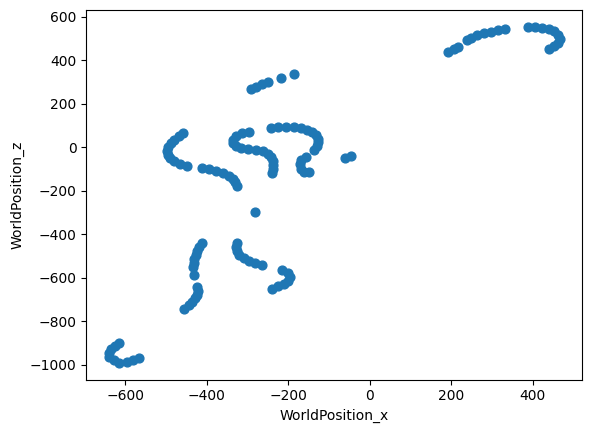

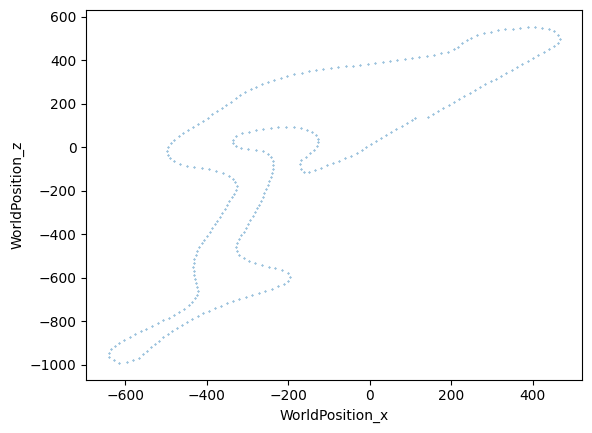

In [12]:
def moving_average(x, w=1):
    return np.convolve(x, np.ones(w), 'valid') / w


yaw_rate = np.diff(laps[0]['yaw_angles'])

idx = np.where(abs(moving_average(yaw_rate))>0.05)[0]+1
plt.figure()
x = laps[0]['points'][idx,0]
y = laps[0]['points'][idx,1]
plt.scatter(x, y, s=40)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

x = laps[0]['points'][:,0]
y = laps[0]['points'][:,1]
plt.scatter(x, y, s=0.1)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

In [13]:







    
def angle(points):
    # This function calculated angles between the points
    differences = np.diff(points, axis=0)
    phi = np.arctan2(differences[:,0], differences[:,1])
    phi = np.unwrap(phi)
    angles = np.diff(phi,axis=0)    
    return angles


class Lap:
    # Class for single lap in the track.
    # Main usage is interpolation.
    def __init__(self, distances, points):
        self.distances, self.points = drop_non_monotonic(distances, points)
        # TODO: change extrapolate with nan filling
        self.interp = interp1d(self.distances, self.points,
                              axis=0, fill_value="extrapolate")

    def __call__(self, distances):
        return np.array(self.interp(distances))
    
    def calculate_yaw_rate(self,):

class Track:
    # Class for single track.
    # Main usage is storage of multiple laps in track and
    # calculate average trajectory with multiple laps
    def __init__(self):
        self.laps = []

    def append(self, distances, points):
        lap = Lap(distances, points)
        self.laps.append(lap)

    def filter(self, dist, filter_range, delta_dist):
        distances = np.arange(dist-filter_range, dist+filter_range, delta_dist)
        multi_lap_distances = []
        multi_lap_points = []
        for lap in self.laps:
            points = lap(distances)
            not_nan_idx = ~np.all(np.isnan(points), axis=1)
            multi_lap_distances.append(distances[not_nan_idx])
            multi_lap_points.append(points[not_nan_idx])

        multi_lap_distances = np.concatenate(multi_lap_distances, axis=0)
        multi_lap_points = np.concatenate(multi_lap_points, axis=0)
        px = np.polyfit(multi_lap_distances, multi_lap_points[:,0], 3)
        py = np.polyfit(multi_lap_distances, multi_lap_points[:,1], 2)
        fx = np.poly1d(px)
        fy = np.poly1d(py)
        return np.array([fx(dist), fy(dist)])

    def get_track_length(self):
        max_length = 0
        for lap in self.laps:
            if lap.distances.max() > max_length:
                max_length = lap.distances.max()
        return max_length

    def get_track_points(self, filter_range=10, delta_dist=2):
        track_length = self.get_track_length()
        distances = np.arange(0, track_length, delta_dist)
        points = np.zeros((distances.shape[0],2))
        for idx in range(distances.shape[0]):
            points[idx, :] = self.filter(distances[idx], filter_range, delta_dist)
        self.points = points
        return points

    def find_turning_points(self, min_angle):
        theta = angle(self.points)
        # Select the index of the points with the greater than min angle
        idx = np.where(abs(theta)>min_angle)[0]+1
        return self.points[idx]


     

IndentationError: expected an indented block after function definition on line 22 (3650084462.py, line 24)

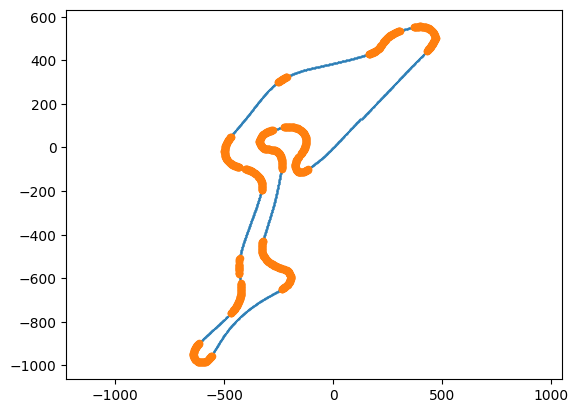

In [ ]:
track_obj = Track()
min_angle = np.pi*0.002
for track, data in tracks.items():
    df = data["df"]
    if data["game"] == "Automobilista 2":
        points = df[['WorldPosition_x','WorldPosition_z']].to_numpy()
        distances = df[['DistanceRoundTrack']].to_numpy()[:,0]
        laps_distances, laps_points = split_laps(distances, points)
        for idx in range(len(laps_distances)):
            track_obj.append(laps_distances[idx], laps_points[idx])
track_points = track_obj.get_track_points()
turning_points = track_obj.find_turning_points(min_angle)

fig, ax = plt.subplots()
plot_points(ax, track_points)
plot_points(ax, turning_points, s=20)
plt.show()           